### 0. Computer vision libraries in PyTorch

https://pytorch.org/vision/stable/transforms.html

* `torchvision` - base domain library for PyTorch
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch
* `torch.utils.data.DataLoader` - Create a Python iterable over the dataset

In [2]:
# Import pytorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib.pyplot as plt
print(torch.__version__) # needs to be in 2.1.1. for torchvision compatibility
print(torchvision.__version__)

2.1.1
0.16.1


### 1. Getting a dataset

The dataset we will be using is Fashion MNIST from torchvision.datasets

In [3]:
# Setup training data
from torchvision import datasets
train_data = datasets.FashionMNIST(
    root = "data",  # where to download data to?
    train = True, #  do we want the training set?
    download = True, # do we want to download?
    transform = ToTensor(), # how do we want to transform the data?
    target_transform = None # how do we want to transform the labels/targets?
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
 # See the first training example
img, label = train_data[0]
img, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [8]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [9]:
# Check the shape of our image
print(f"Image shape: {img.shape} -> [color_channels, height, width]")
print(f"Label: {label} -> {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label: 9 -> Ankle boot


#### 1.2 Visualize the data

Image shape: torch.Size([1, 28, 28])


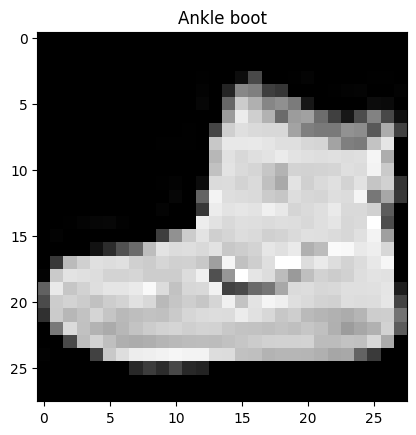

In [10]:
import matplotlib.pyplot as plt
img, label = train_data[0]
print(f"Image shape: {img.shape}")
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label]);

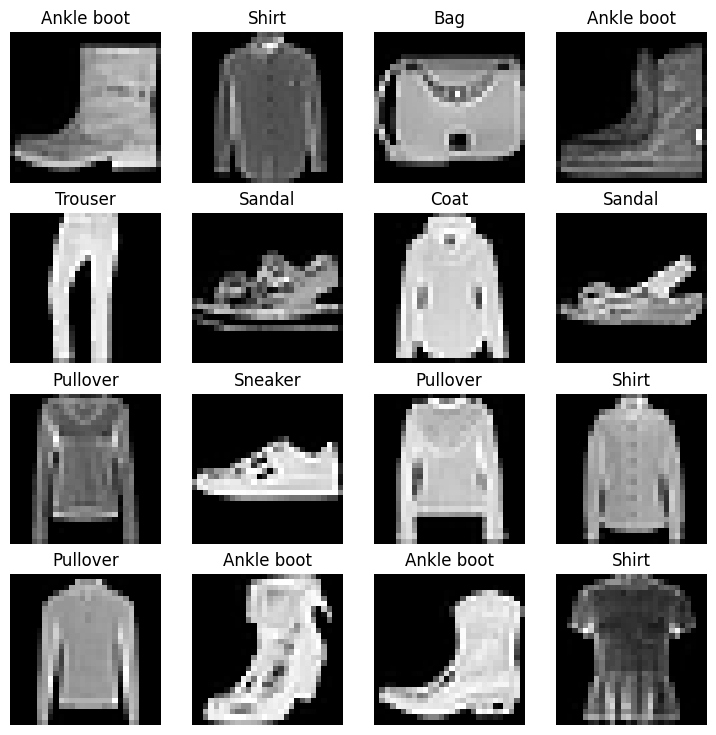

In [11]:
# plot more images
torch.manual_seed(42)
fig = plt.figure(figsize = (9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis("off")

Do you think these items of clothing (images) could be modelled with pure linear lines? or do you think we'll need non-linearity?

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### 3. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).

2. It gives our neural network more chances to update its gradients per epoch.

For more on mini-batches see Andrew Ng on mini-batches.

In [13]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16bc7f850>,
 <torch.utils.data.dataloader.DataLoader at 0x16b98af10>)

In [14]:
# Let's check out hwat we've created
print(f"DataLoader: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x16bc7f850>, <torch.utils.data.dataloader.DataLoader object at 0x16b98af10>)
Length of train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [15]:
10000 / 32

312.5

In [16]:
# Check out what's inside the training DataLoader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


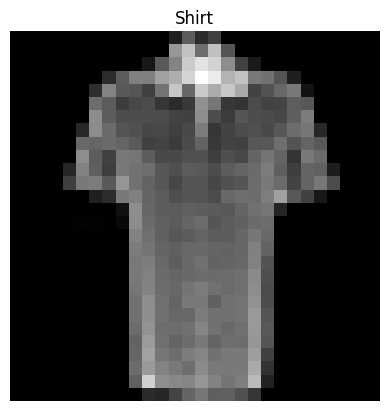

In [17]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

### 3. Model 0: Build a baseline model
When starting to build a series of machine learning modeling experiments, it's best practice to start with a baseline model.

A baseline model is a smiple model you will try and improve upon with subsequent models/experiments.ExceptionGroup

In other words: start simply and add complexity when necessary.

In [18]:
# Create a flatten layer
flatten_model = nn.Flatten() 

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [19]:
output

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0039, 0.0000, 0.0000, 0.0078, 0.0078,
         0.0000, 0.0000, 0.0039, 0.0078, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.2863, 0.0000, 0.0

In [20]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, 
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, 
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units, 
                      out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [21]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [22]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [23]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 setup loss, optimizer, and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification proble, let's use accuracy as an evaluation metric

In [24]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py exists, skipping download...")
else:
    print("Downloading helper_functions.py...")
    url = "https://raw.githubusercontent.com/mrdbourke/learn-the-transformer/master/helper_functions.py"
    r = requests.get(url)
    with open("helper_functions.py", "wb") as file:
        file.write(r.content)

helper_functions.py exists, skipping download...


In [25]:
# Import accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), 
                             lr=0.01)

#### 3.4 Creatinga  function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1.  Model's performance (loss and accuracy values etc)
2. How fast it runs

In [26]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Training time on {device}: {total_time:.4f} seconds")
    return total_time

In [27]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start_time, end_time, device="cpu")

Training time on cpu: 0.0000 seconds


8.207978680729866e-06

#### 3.3 Creating a training loop and training a model on batches of data

1. loop through epochs.
2. Loop trhough training batches, perform training steps, calculate the test loss per batch.
3. loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print what happened
5. Time it all (for fun).

In [28]:
# import tqdm for progress bar
from tqdm.auto import tqdm

# set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")

    # Training
    train_loss = 0

    # Add a loop to loop through the training batches
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss for this epoch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/ {len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader) # average out the loss for the entire epoch

    ### Testing
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test)
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader) # average out the loss for the entire epoch
        test_acc /= len(test_dataloader)
    
    # Print out the information
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu, 
                                     train_time_end_on_cpu, 
                                     device=str(next(model_0.parameters()).device))


/Users/amyfan/Desktop/pytorch-walkthrough/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------


Looked at 0/ 60000 samples.
Looked at 12800/ 60000 samples.
Looked at 25600/ 60000 samples.
Looked at 38400/ 60000 samples.
Looked at 51200/ 60000 samples.


 33%|███▎      | 1/3 [00:02<00:04,  2.02s/it]

Train Loss: 0.5645 | Test Loss: 0.5088, Test acc: 82.2384
Epoch: 1
--------
Looked at 0/ 60000 samples.
Looked at 12800/ 60000 samples.
Looked at 25600/ 60000 samples.
Looked at 38400/ 60000 samples.
Looked at 51200/ 60000 samples.


 67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]

Train Loss: 0.5013 | Test Loss: 0.4899, Test acc: 83.0471
Epoch: 2
--------
Looked at 0/ 60000 samples.
Looked at 12800/ 60000 samples.
Looked at 25600/ 60000 samples.
Looked at 38400/ 60000 samples.
Looked at 51200/ 60000 samples.


100%|██████████| 3/3 [00:05<00:00,  1.87s/it]

Train Loss: 0.4809 | Test Loss: 0.5726, Test acc: 80.4712
Training time on cpu: 5.6592 seconds


### 4. Make predictions and get Model 0 results

In [29]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """ Returns a dictionary containing the results of model predicting on data_loader. """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_pred = model(X)
            
            # Calculate loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, #only works when model was created with a class,
            "model_loss": loss.item(), 
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model_0, 
                             test_dataloader, 
                             loss_fn, 
                             accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:00<00:00, 1672.32it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5725629329681396,
 'model_acc': 80.47124600638978}

### 5. Setup device agnostic code (for using GPU if there is one)

In [30]:
from functions import get_device
# Setup device-agnostic code
import torch
device = get_device()
device

'mps'

### 6. Model 1: Building a better model with non-linearity

In [31]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,
                 input_shape: int,
                 output_shape: int,
                 hidden_units: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, 
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, 
                      out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

# Try on MPS device
model_1 = FashionMNISTModelV1(input_shape=784,
                              output_shape=len(class_names),
                              hidden_units=10).to(device)
next(model_1.parameters()).device

device(type='mps', index=0)

#### 6.1 Setup loss, optimizer and evaluation metrics

In [32]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss().to(device)    # measure how wrong our model is
optimizer = torch.optim.Adam(model_1.parameters(), # tries to update our model's parameters to reduce the loss
                             lr=0.01)

#### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* Training loop: - `train_step()`
* Testing loop - `test_step()`

In [33]:
def train_step(model: torch.nn.Module,
               train_dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Training step of the model on data from train_dataloader."""
    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(train_loss, len(train_dataloader))
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}")

In [34]:
def test_step(model: torch.nn.Module,
              test_dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """ testing step of the model on data from test_dataloader. """
    test_loss, test_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}")

In [35]:
from timeit import default_timer as timer

torch.manual_seed(42)

# Measure training time
train_time_start_on_mps = timer()

epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-----")
    train_step(model_1, 
                train_dataloader, 
                loss_fn, 
                optimizer, 
                accuracy_fn,
                device=device)
    test_step(model_1,
                test_dataloader,
                loss_fn,
                accuracy_fn,
                device=device)
    
train_time_end_on_mps = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_mps, 
                                     train_time_end_on_mps, 
                                     device=device)

Epoch: 0
-----
tensor(2349.8555, device='mps:0', grad_fn=<AddBackward0>) 1875
Train loss: 1.2533, Train acc: 56.89
Test loss: 1.0654, Test acc: 63.84
Epoch: 1
-----
tensor(1952.0106, device='mps:0', grad_fn=<AddBackward0>) 1875
Train loss: 1.0411, Train acc: 63.77
Test loss: 1.0405, Test acc: 64.06
Epoch: 2
-----
tensor(1912.9529, device='mps:0', grad_fn=<AddBackward0>) 1875
Train loss: 1.0202, Train acc: 64.25
Test loss: 1.0421, Test acc: 64.01
Training time on mps: 23.6426 seconds


**Note:** Sometimes, depending on your data/hardware, you might find that your model trains faster on CPU than GPU.

Why is this?

1. It could be that the overhead for copying data/model to and from the GPU outweighs the compute benefits offered by the GPU
2. The hardware you're using has a better CPU in terms compute capability than GPU.


"How to make your GPU go Brrrr by Horace"

In [36]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """ Returns a dictionary containing the results of model predicting on data_loader. """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)
            
            # Calculate loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, #only works when model was created with a class,
            "model_loss": loss.item(), 
            "model_acc": acc}

# Get model_1 results dictionary
model_1_results = eval_model(model_1, 
                             test_dataloader, 
                             loss_fn, 
                             accuracy_fn)
model_1_results

100%|██████████| 313/313 [00:00<00:00, 640.85it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 1.0420796871185303,
 'model_acc': 64.00758785942492}

In [37]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.5725629329681396,
 'model_acc': 80.47124600638978}

### Model  2: Building a Convolutional Neural Network (CNN)

CNN's are also known as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

Terminology:
1. Input size: 4 -> 4x4; inputs are square matrices
2. Padding: Increases size by adding 2 * padding; 4x4 input with 3 padding -> 10x10 output; 2 for each padded layer (1 on each edge)
3. Kernel size: Decreases size by kernel - 1; 4x4 input with 2 kernel -> 3x3 output; 1 doesn't change the size, but every additional size removes one movement.
4. Stride: Only restricted value, any factor of (after-padding size - kernel); after-padding 8x8 with kernel size 2 and 2 stride -> 8-2=6 so 1,2,3,6 strides work

Intution: The first kernel appears -> then there is however much left over. That amount leftover is the max stride size. Then, all possible stride sizes are that size and its factors (so that it can incrementally move towards filling up the full leftover from the first kernel).

In [41]:
# Create a convolutational neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            # create a conv layer
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # 3x3 filter
                      stride=1,
                      padding=1), # thses are the hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, # 2x2 filter
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.flatten = nn.Sequential(
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,    # there's a trick to calculating this... (print previous layers output shape)
                        out_features=output_shape),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        print(f"Output shape of conv_block_2: {x.shape}")
        x = self.flatten(x)
        print(f"Output shape after flattening: {x.shape}")
        x = self.classifier(x)
        print(f"Output shape of classifier: {x.shape}")
        return x

In [43]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [ ]:
rand_image_tensor = torch.rand([1,28,28])
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
# Ensure device is same
next(model_2.parameters()).device, rand_image_tensor.device

# Pass image through model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0372, -0.0748,  0.0573, -0.0396, -0.0098,  0.0194, -0.0003, -0.0114,
          0.0206,  0.0003]], device='mps:0', grad_fn=<LinearBackward0>)

#### 7.1 Stepping through `nn.Conv2d()`

See the documentation for `nn.Conv2d()`

In [ ]:
torch.manual_seed(42)

# Creating a batch of images
images = torch.randn(size = (32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
torch.manual_seed(42)
# Create a sinlge conv2d layer
conv_layer = nn.Conv2d(in_channels=3, 
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

# Pass the data through the convolutional layer 
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape

torch.Size([1, 10, 64, 64])

#### 7.2 Stepping through `nn.Maxool2d()`

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
# Print out original image shape without unsqueezing (necessary for older torch versions)
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueeze: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
# test_image_through_conv = conv_layer(test_image.unsqueeze(0)) # both work since this is the new version
test_image_through_conv = conv_layer(test_image) 
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through max_pool_layer(): {test_image_through_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueeze: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([10, 64, 64])
Shape after going through max_pool_layer(): torch.Size([10, 32, 32])


In [ ]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(1,1,2,2)
print(f"\nRandom tensor:\n {random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
random_max_pool = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
random_max_pool_output = random_max_pool(random_tensor)
print(f"\nMax pool layer output:\n {random_max_pool_output}")
print(f"Max pool layer output shape: {random_max_pool_output.shape}")


Random tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool layer output:
 tensor([[[[0.3367]]]])
Max pool layer output shape: torch.Size([1, 1, 1, 1])


#### 7.3 Setup a loss function and optimizer for `model_2`

In [ ]:
# Setup loss function / eval metrics / optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_2.parameters(), 
                             lr=0.01)

In [ ]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [44]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_mps = timer()

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model_2, 
                train_dataloader, 
                loss_fn, 
                optimizer, 
                accuracy_fn,
                device=device)
    test_step(model_2,
                test_dataloader,
                loss_fn,
                accuracy_fn,
                device=device)
    
# Calculate training time
train_time_end_on_mps = timer()
total_train_time_model_2 = print_train_time(train_time_start_on_mps, 
                                     train_time_end_on_mps, 
                                     device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7

  0%|          | 0/3 [00:08<?, ?it/s]

Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape after flattening: torch.Size([32, 490])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape

KeyboardInterrupt: 

In [ ]:
# Get model_2 results
model_2_results = eval_model(model_2, 
                             test_dataloader, 
                             loss_fn, 
                             accuracy_fn)
model_2_results

100%|██████████| 313/313 [00:00<00:00, 318.08it/s]


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.37934085726737976,
 'model_acc': 86.0123801916933}

### 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.572563,80.471246
1,FashionMNISTModelV1,1.042080,64.007588
2,FashionMNISTModelV2,0.379341,86.012380


In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0, # faster since on cpu in this hardware
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.572563,80.471246,6.003427
1,FashionMNISTModelV1,1.042080,64.007588,22.645898
2,FashionMNISTModelV2,0.379341,86.012380,40.541642


Text(0, 0.5, 'model')

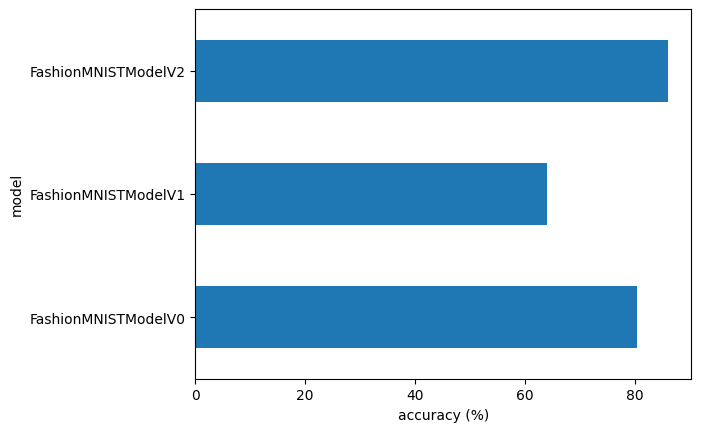

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh") # "bar" is a vertical barplot
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### 9. Make and evaluate random predictions with best model

In [51]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, 0).to(device)

            # Forward pass (model outputs raw logits)
            print(f"sample shape: {sample.shape}")
            pred_logit = model(sample)

            # Get prediction probability (logit -> probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off the MPS for further calculations
            pred_probs.append(pred_prob.cpu())
        
    # Stack the pred_probs to list into a tensor
    return torch.stack(pred_probs)

In [ ]:
print(f"length of test data: {len(test_data)}") # size 10000 dataset
print(f"length of first tuple in test data: {len(test_data[0])}") # size 2 (image, label)
print(f"shape of first image its corresponding label: {test_data[0][0].shape} with label {test_data[0][1]} ") # size 1x28x28


length of test data: 10000
length of first tuple in test data: 2
shape of first image its corresponding label: torch.Size([1, 28, 28]) with label 9 


In [52]:
import random 
# random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), 9):   # 'sample' is the image
    test_samples.append(sample)
    test_labels.append(label)


# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Shirt')

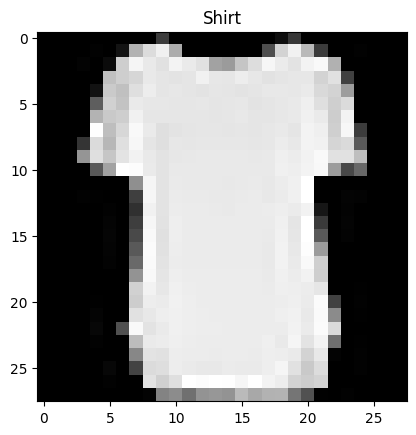

In [46]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [53]:
# Make predictions
pred_probs = make_predictions(model=model_2, 
                              data=test_samples)

# view first two prediction probabilities
pred_probs[:2]

sample shape: torch.Size([1, 1, 28, 28])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
sample shape: torch.Size([1, 1, 28, 28])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
sample shape: torch.Size([1, 1, 28, 28])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
sample shape: torch.Size([1, 1, 28, 28])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape after flattening: torch.Size([1, 490])
Output shape of classifier: 

tensor([[0.1029, 0.0938, 0.1045, 0.0969, 0.0988, 0.1016, 0.0999, 0.0985, 0.1022,
         0.1009],
        [0.1028, 0.0939, 0.1052, 0.0972, 0.0983, 0.1011, 0.0994, 0.0989, 0.1024,
         0.1008]])

In [ ]:
# Convert prediction probabilities to class labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 4, 7, 0, 9, 6, 4, 7, 4])

(-0.5, 27.5, 27.5, -0.5)

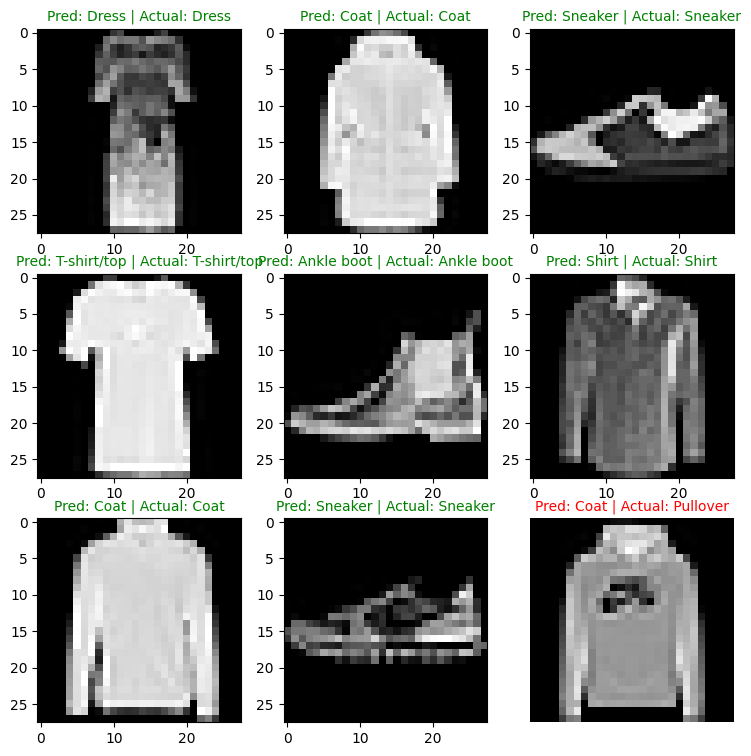

In [ ]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes[i]]

    # Get the truth label (in text form)
    true_label = class_names[test_labels[i]]

    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Actual: {true_label}"

    # Check for equality between pred and truth and hange color of title text
    if pred_label == true_label:
        plt.title(title_text, fontsize=10, color="green")
    else:
        plt.title(title_text, fontsize=10, color="red")
plt.axis(False)

### 10. Making a Confusion Matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually

1. Make predictions with our trained model on the test dataset (shown just above)
2. Make a confusion matrix `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send the data and labels to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model_2(X)
        # Turn preidctions from logits -> probs -> labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Append batch predictions to list
        y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]
len(y_pred_tensor)


Making predictions...: 100%|██████████| 313/313 [00:00<00:00, 367.95it/s]


10000

In [ ]:
# See if required packages are installed and if not, install them...
try: 
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(torchmetrics.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

import mlxtend
print(mlxtend.__version__)

mlxtend version: 0.23.1
mlxtend version: 0.23.1
0.23.1


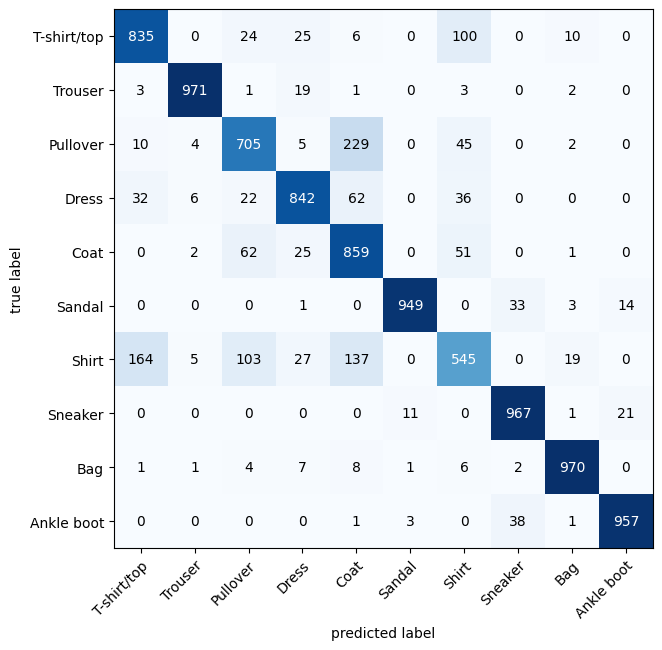

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task = 'multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix 
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10,7)
)

## 11. Save and load best performing model
Check loaded model using `torch.isclose()` and set aotl to at highest 1e-02.

In [1462]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME ="03_computer_vision_model_2.pth" # convention to save PyTorch models with .pth extension
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME # syntax for Pathlib Path

# 3. Save model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), 
           f=MODEL_SAVE_PATH)

!ls -l models # should say etc...@ 1 amyfan ...etc...

Saving model to: models/03_computer_vision_model_2.pth
total 96
-rw-r--r--@ 1 amyfan  staff   1750 Dec 10 00:15 01_pytorch_exerices_model_ex.pth
-rw-r--r--@ 1 amyfan  staff   1568 Dec 10 00:04 01_workflow_model_0.pth
-rw-r--r--@ 1 amyfan  staff   1632 Dec  9 22:25 01_workflow_model_1.pth
-rw-r--r--@ 1 amyfan  staff  35138 Mar  5 22:14 03_computer_vision_model_2.pth


In [1487]:
# Need to load the state dict into something: instantiate a new instance of our model class
loaded_model = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))

# Load saved state_dict into this model
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [1526]:
# Evaluate loaded model METHOD 1
loaded_model.eval() 
with torch.inference_mode():
    loaded_model_preds = loaded_model.to('cpu')(X_test)
    y_preds = model_2(X_test.to(device)) # run to get correct y_preds values, y_preds got saved somewhere else from previous lines of code.

torch.isclose(loaded_model_preds.to(device), y_preds, atol=1e-6).all()

tensor(True, device='mps:0')

In [1528]:
# Evaluate loaded model METHOD 2
loaded_model_results = eval_model(
    loaded_model.to(device),
    test_dataloader,
    loss_fn,
    accuracy_fn,
)
torch.isclose(torch.tensor(loaded_model_results['model_loss']),
              torch.tensor(loaded_model_results['model_loss'])).all()

100%|██████████| 313/313 [00:00<00:00, 383.64it/s]


tensor(True)